<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/Financial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy==1.19.5

     |████████████████████████████████| 14.8 MB 5.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [ ]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8 MB 23 kB/s 
     |████████████████████████████████| 449 kB 67.5 MB/s 
     |████████████████████████████████| 3.8 MB 35.5 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d36d23341e730a53fd52eeb713027ae7cd7da303dd8321bc4a05f0b6c7ea84ad
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from IPython.display import clear_output

import pandas as pd
import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
filename = '/content/drive/MyDrive/Financial_data/Kospi_sample_20yr.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.8.0
GPU 사용 가능 여부: False


#Data Indexing and plotting

In [ ]:
date_index = data[['Date','End']]
date_index = date_index.copy()
#복사해서 사용시 Dateframe 오류 방지 가능 .loc사용해도 됨.
#https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","").apply(int)
date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)

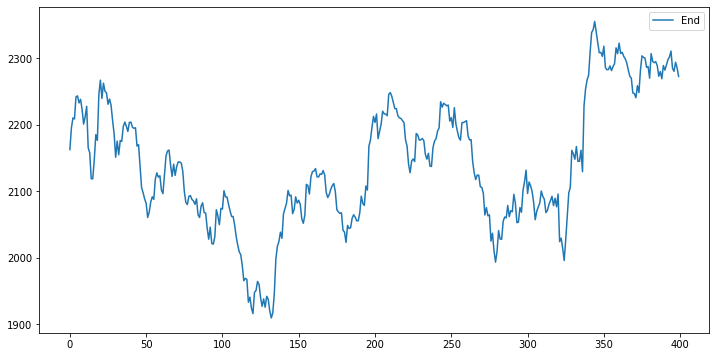

In [ ]:
fig = plt.subplots(figsize=(12,6))
ax = plt.gca()
date_index.plot(y='End', ax=ax)
plt.show()

# Denoise the serial data by Fourier Transform

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


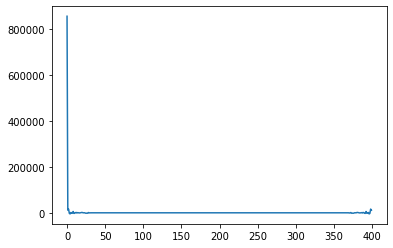

In [ ]:
def FFT(df, col, topn=2):
    fft = np.fft.fft(df[col])
    fft[topn:-topn] = 0
    ifft = np.fft.ifft(fft)
    plt.plot(fft)
    return ifft

date_index['Fourier'] = FFT(date_index,'End', 30)

# Result of denosing

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


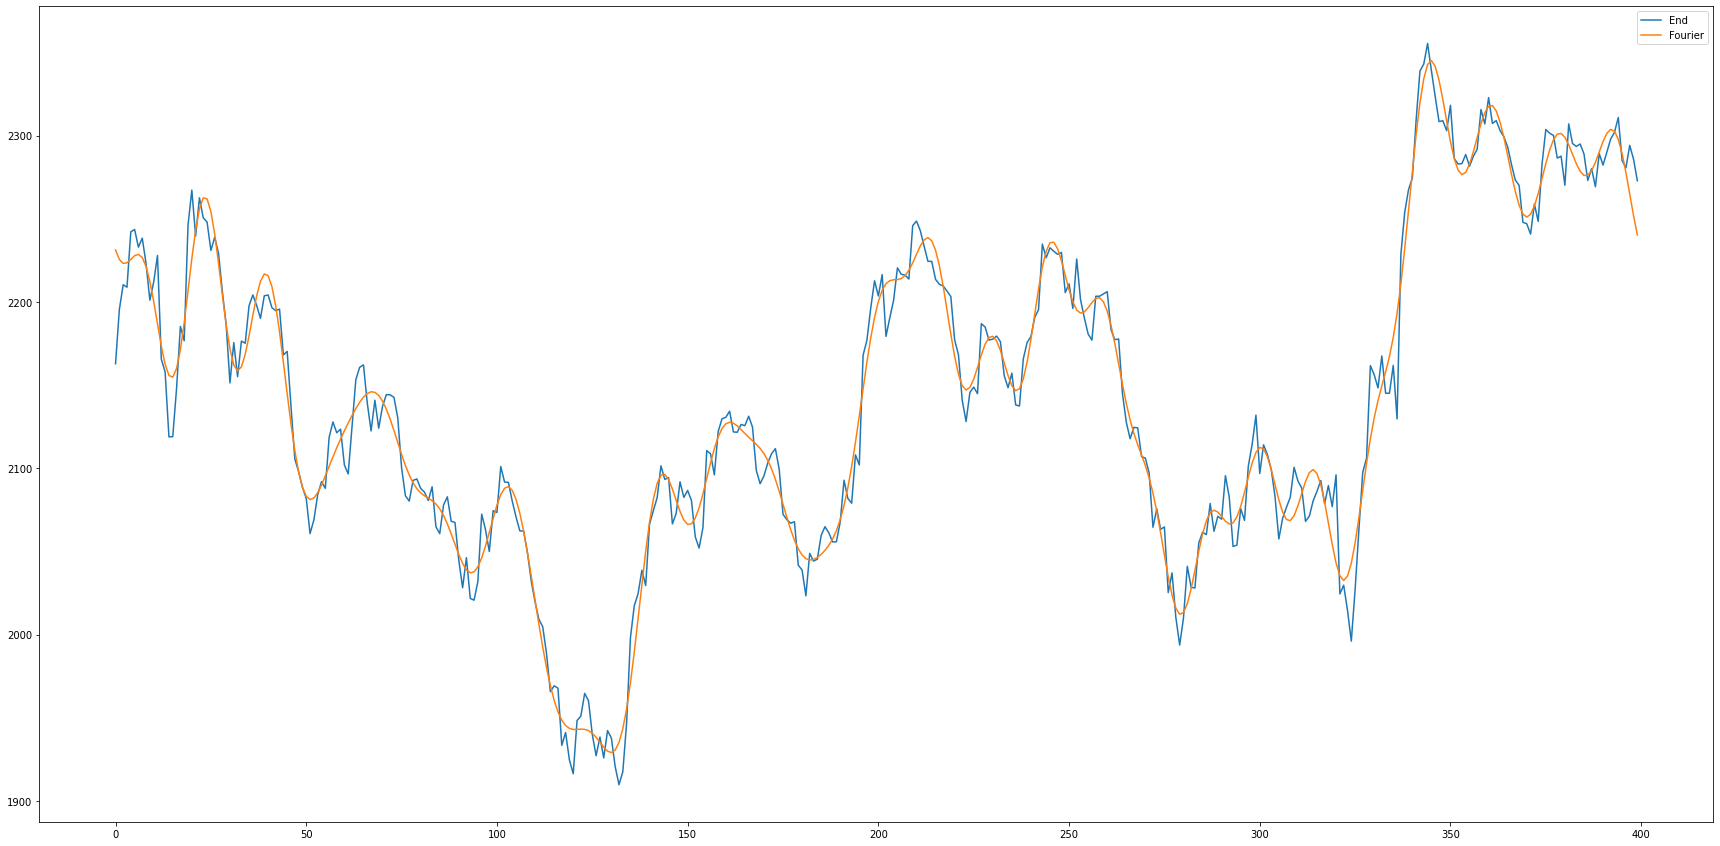

In [ ]:
fig = plt.subplots(figsize=(30,15))
ax = plt.gca()
date_index.plot(y='End',ax=ax)
date_index.plot(y='Fourier', ax=ax)
plt.show()

#AutoEncoder

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__() 
        self.module = module 
    def forward(self, x):
        if len(x.size()) <= 2: 
            return self.module(x) 
        x_reshape = x.contiguous().view(-1, x.size(-1)) 
        y = self.module(x_reshape) 
        if len(x.size()) == 3: 
            y = y.contiguous().view(x.size(0), -1, y.size(-1)) 
        return y

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encoder = nn.LSTM( input_size = 1,hidden_size = 16, dropout = 0.25, num_layers = 2, bias = True, batch_first = True, bidirectional = True,) 
        self.decoder = nn.LSTM( input_size = 32, hidden_size = 16, dropout = 0.25, num_layers = 2, bias = True, batch_first = True, bidirectional = True, ) 
        self.fc = TimeDistributed(nn.Linear(32, 1)) 
        
    def forward(self, x): 
        h0, (h_n, c_n) = self.encoder(x) 
        h0, (h_n, c_n) = self.decoder(h0[:,-1:,:].repeat(1,5,1)) 
        out = self.fc(h0)
        return out

def printout():
  TimeDistributed()

NameError: ignored

#Making Train set, Validation set, Test set

---



In [ ]:
batch_size = 120
max_epochs = 50
learning_rate = 3e-5
hidden_sizes = [100, 100]

In [ ]:
def preprocess(all_files):
  data0 = []
  data1 = []
  data2 = []
  data3 = []
  for f in all_files:
    with open(f, encoding='UTF-8') as c:
      csvReader = csv.reader(c, delimiter=',')
      header = True
      for col in csvReader:
        if header:
          header = False
          continue
        data0.append(float(col[1].replace(',',''))) if col[1] != '' else data0.append(0.0)
        #data0 = FFT(data0,50)
        data1.append(float(col[2].replace(',',''))) if col[2] != '' else data1.append(0.0)
        #data1 = FFT(data1,50)
        data2.append(float(col[3].replace(',',''))) if col[3] != '' else data2.append(0.0)
        #data2 = FFT(data2,50)
        data3.append(float(col[4].replace(',',''))) if col[4] != '' else data3.append(0.0)
        #data3 = FFT(data3,50)
  data = np.zeros((len(data0), 4))
  for i, d in enumerate(data):
    data[i, 0] = data0[i]
    data[i, 1] = data1[i]
    data[i, 2] = data2[i]
    data[i, 3] = data3[i]
  return data.astype(np.complex128)

In [ ]:
data_dir = 'Financial_data/Data'
train_data = preprocess(glob.glob(os.path.join(data_dir, 'train', '*')))
val_data = preprocess(glob.glob(os.path.join(data_dir, 'val', '*')))
test_data = preprocess(glob.glob(os.path.join(data_dir, 'test', '*')))

In [ ]:
#fig = plt.subplots(figsize=(12,6))
#ax = plt.gca()
#train_data.plot(y=train_data.iloc[:, [2]], ax=ax)
#train_data.astype(complex)
#plt.plot(train_data[0])
#plt.show()

In [ ]:
print("shape of train data: {}".format(train_data.shape))
print("shape of val data: {}".format(val_data.shape))
print("shape of test data: {}".format(test_data.shape))

shape of train data: (5998, 4)
shape of val data: (2000, 4)
shape of test data: (5999, 4)


#10yr Train data Plotting

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


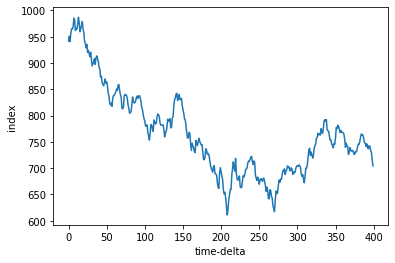

In [ ]:
start = 0
dt = 400
train_data = np.flipud(train_data)
plt.plot(train_data[start:start+dt, 0])
plt.ylabel("index")
plt.xlabel("time-delta")
plt.show()

TypeError: ignored

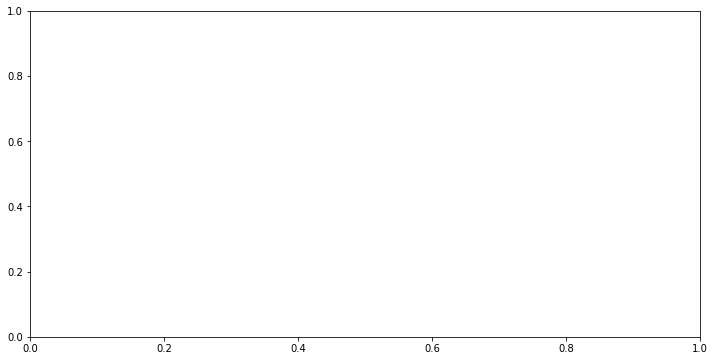

In [ ]:
data_df = pd.DataFrame(train_data)
fig = plt.subplots(figsize=(12,6))
ax = plt.gca()
data_df.plot(y= data_df[0], ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


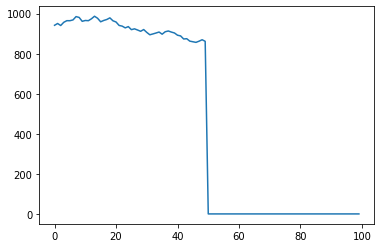

In [ ]:
dt = 100
from pandas.core.arrays.numeric import T
def FFT(df, topn=2):
    fft = np.fft.fft(df)
    fft[topn:-topn] = 0 
    ifft = np.fft.ifft(fft)
    return ifft

train_data = FFT(train_data, 50)
train_data.astype(complex)

plt.plot(train_data[start:start+dt, 0])
plt.show()

In [ ]:
def make_dataset(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    if mode is 'train':
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
    else: 
        mean = train_mean
        std = train_std         #val 또는 test 모드일 때: train_mean, train_std를 이용
    data = (data - mean) / std  #normalize
    
    # 입력, 타겟 데이터 생성
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:
            
            sequence.append(data[index:index+seq_length])    #모델에게 전달되는 입력 데이터가 됩니다.
            target.append(data[index+seq_length-target_delay][0])      #  data의 index부터 seq_length만큼의 떨어진 위치에서 다시 target_delay 만큼 떨어진 위치의 가격 target에 추가

    if mode is 'train':
        return np.array(sequence), np.array(target), mean, std
    else:
        return np.array(sequence), np.array(target)

In [ ]:
train_sequences, train_labels, train_mean, train_std = make_dataset(train_data, mode='train')
print(train_sequences)
print(train_labels)
print(train_mean)
print(train_std)
val_sequences, val_labels = make_dataset(val_data, mode='val', train_mean=train_mean, train_std=train_std)
#print(val_sequences)
#print(val_labels)
test_sequences, test_labels = make_dataset(test_data, mode='test', train_mean=train_mean, train_std=train_std)

[[[ 2.1101089 +0.j  2.12617095+0.j  2.12318675+0.j  2.12218593+0.j]
  [ 2.13240016+0.j  2.10906105+0.j  2.13660735+0.j  2.122412  +0.j]
  [ 2.10726001+0.j  2.13333963+0.j  2.13745235+0.j  2.11939773+0.j]
  ...
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]]

 [[ 2.16728649+0.j  2.1662356 +0.j  2.17254472+0.j  2.16747543+0.j]
  [ 2.17698269+0.j  2.16596084+0.j  2.16533736+0.j  2.17905528+0.j]
  [ 2.21841646+0.j  2.17682625+0.j  2.20987386+0.j  2.19055977+0.j]
  ...
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]
  [-0.24319402+0.j -0.24323796+0.j -0.2433364 +0.j -0.24316698+0.j]]

 [[ 2.17003542+0.j  2.15836754+0.j  2.16071471+0.j  2.15612166+0.j]
  [ 2.16748642+0.j  2.17163083+0.j  2.17570105+0.j  2.17915575+0.j]
  [ 2.19110216+0.j  2.16780921+0

In [ ]:
# shuffle의 인자로 buffer_size, 전체 데이터셋 갯수로
N = BUFFER_SIZE = len(train_sequences) # number of samples in train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))
test_dataset = test_dataset.batch(batch_size)

#푸리에 변환 통한 smoothing

> 들여쓴 블록



         Date      End                Fourier
0    20200221  2162.84  2221.274884-0.061647j
1    20200220  2195.50  2210.955150-0.019114j
2    20200219  2210.34  2207.494686+0.034616j
3    20200218  2208.88  2210.456181+0.068068j
4    20200217  2242.17  2218.140760+0.061647j
..        ...      ...                    ...
395  20180712  2285.06  2305.452627+0.068068j
396  20180711  2280.62  2294.452527+0.061647j
397  20180710  2294.16  2277.433401+0.019114j
398  20180709  2285.80  2257.279564-0.034616j
399  20180706  2272.87  2237.481736-0.068068j

[400 rows x 3 columns]


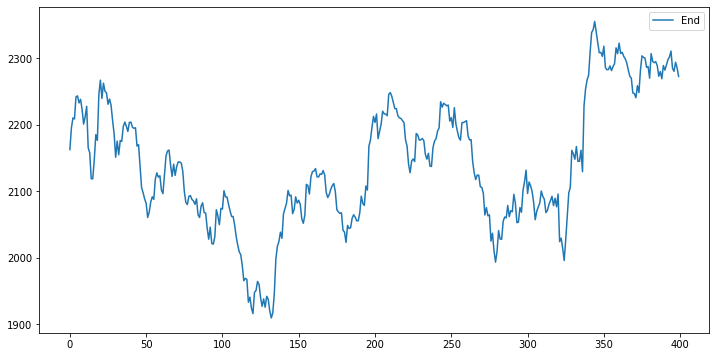

In [ ]:
print(date_index)
fig = plt.subplots(figsize=(12,6))
ax = plt.gca()
date_index.plot(y='End', ax=ax)
plt.show()

[ 8.56242310e+05+0.00000000e+00j  1.15169967e+04+1.02157344e+04j
  1.61539494e+04-1.11847879e+03j -2.58256099e+03+7.55142873e+03j
 -4.84754213e+03+2.32961140e+03j  1.38177017e+03-7.84125460e+02j
 -1.52623235e+03-3.92497869e+03j -1.89325648e+03+1.58173957e+03j
  5.65360585e+03-1.35136986e+03j -2.41992589e+03+5.14921470e+03j
 -1.97404676e+03+1.81627424e+03j  5.14654288e+02+1.97408738e+03j
  1.61183220e+03-1.93893665e+03j -8.27872273e+02-3.71512505e+02j
  8.08830335e+02+3.83393579e+02j  3.67900871e+01+6.99779362e+02j
 -6.65062230e+02+1.38469747e+03j -1.74602674e+02-1.47400112e+02j
  4.10323556e+02-1.43684407e+02j  1.42119536e+03+3.18442401e+02j
  1.35111658e+03-1.65188490e+03j -1.56285024e+01-1.10733704e+03j
 -5.38565126e+01+6.32338168e+02j  1.72193103e+02-9.57564019e+02j
 -1.23438704e+03+5.69549766e+02j -1.94300344e+03+3.62669325e+02j
 -1.33549719e+03+3.44988441e+02j -1.85821966e+03-3.53592401e+02j
  1.10737167e+03-2.33391935e+02j -2.29153073e+02+9.58384949e+02j
 -8.50742384e+02+4.035267

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


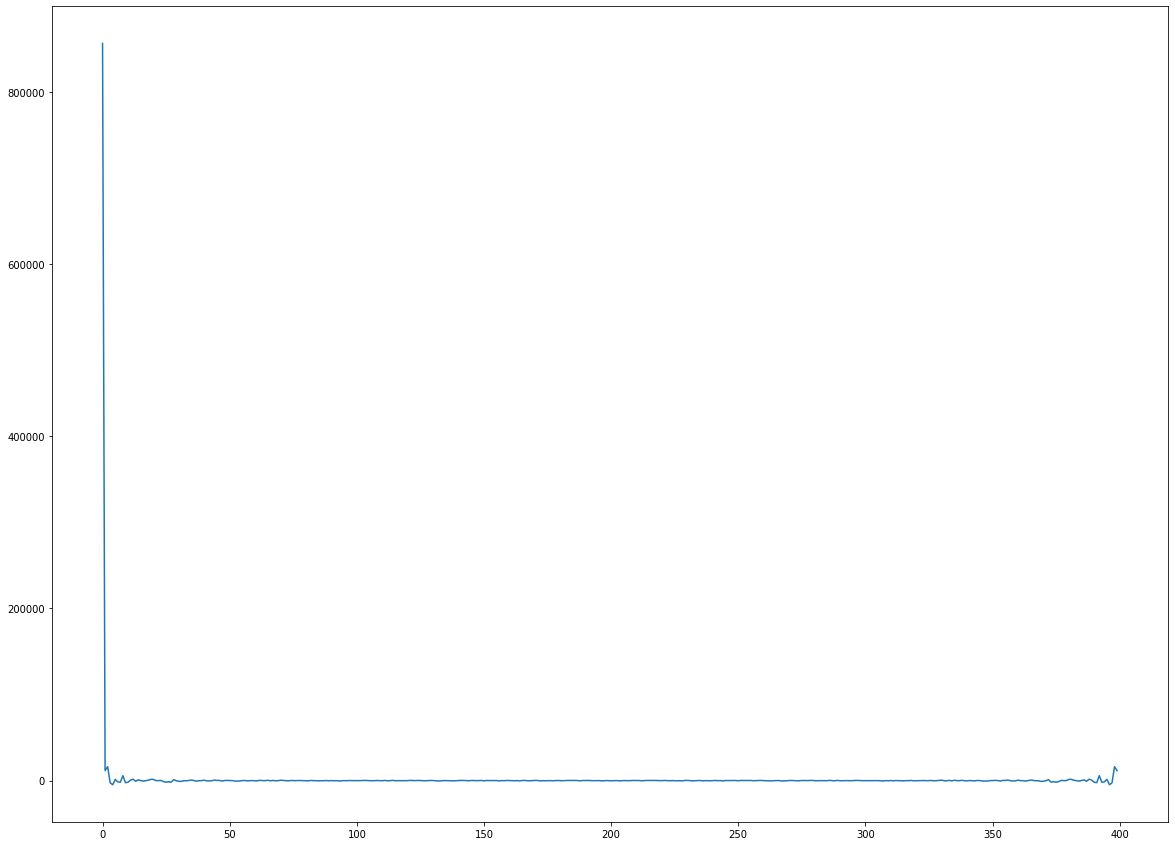

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


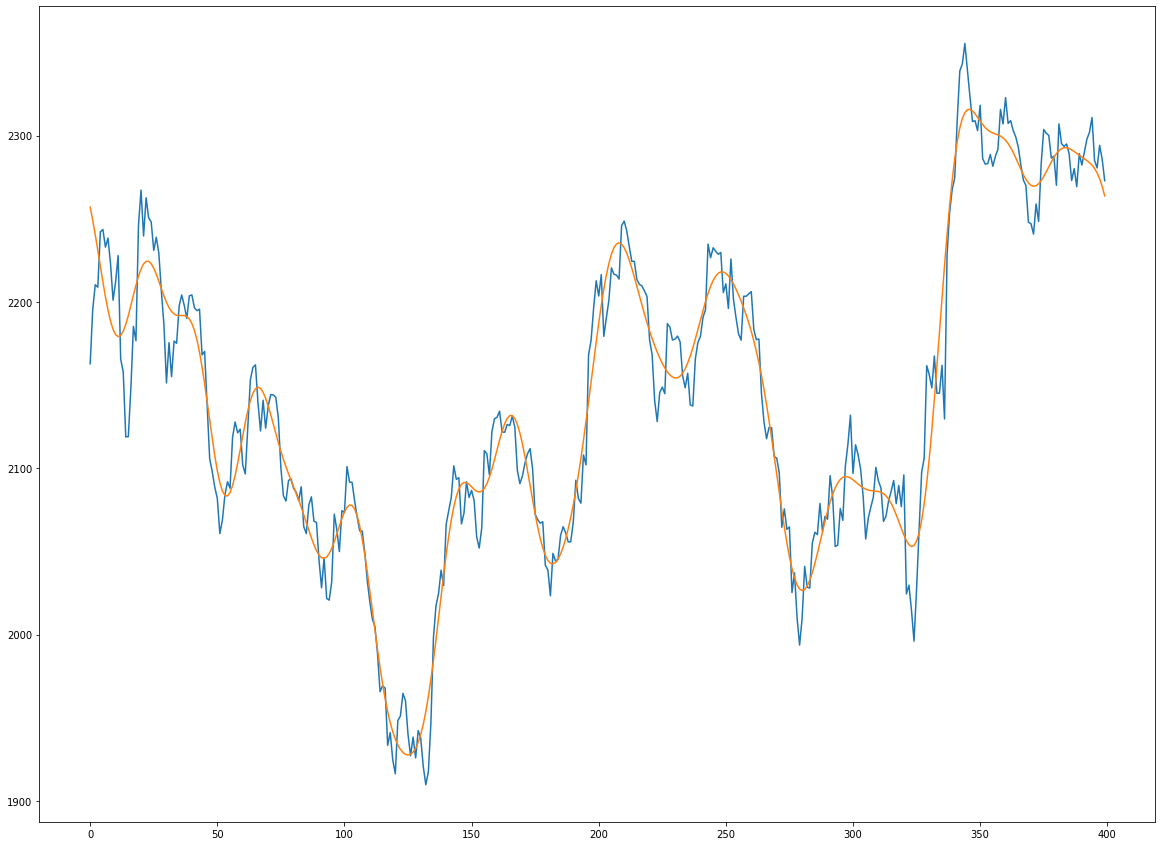

In [ ]:
#주파수 분석
fig = plt.subplots(figsize=(20,15))
sp = np.fft.fft(date_index['End'])
freq = np.fft.fftfreq(date_index['End'].shape[0])
print(sp)
plt.plot(sp)
plt.show()

csp = np.copy(sp)
csp[20:-20] = 0
#print(csp)

iffted_index_price = np.fft.ifft(csp)
fig = plt.subplots(figsize=(20,15))
plt.plot(date_index['End'])
plt.plot(iffted_index_price)
plt.show()

#DSP


In [ ]:
filename = '/content/drive/MyDrive/Financial_data/Kospi_sample_20yr.csv'
df_original = pd.read_csv(filename, sep=",",encoding='UTF-8')
df_original['Date'] = df_original.Date.apply(str).str.replace("년 ","-").str.replace("월 ","-").str.replace("일","")
df_original.index = df_original.Date
#df_original = df_original.sort_values(by='Date', ascending=True)
df_original.head()

,Date,End,Open,Highest,Lowest,Amount,Variation%
Date,,,,,,,
2020-02-21,2020-02-21,"2,162.84","2,165.65","2,184.43","2,160.28",635.47M,-1.49%
2020-02-20,2020-02-20,"2,195.50","2,223.55","2,228.18","2,186.72",709.56M,-0.67%
2020-02-19,2020-02-19,"2,210.34","2,222.51","2,226.00","2,191.20",591.16M,0.07%
2020-02-18,2020-02-18,"2,208.88","2,225.98","2,232.93","2,205.21",470.42M,-1.48%
2020-02-17,2020-02-17,"2,242.17","2,243.07","2,250.05","2,230.26",458.25M,-0.06%


In [ ]:
df = df_original[:400]
df = df[['End']]
df.head()

,End
Date,
2020-02-21,"2,162.84"
2020-02-20,"2,195.50"
2020-02-19,"2,210.34"
2020-02-18,"2,208.88"
2020-02-17,"2,242.17"


Text(0.5, 1.0, 'Index value')

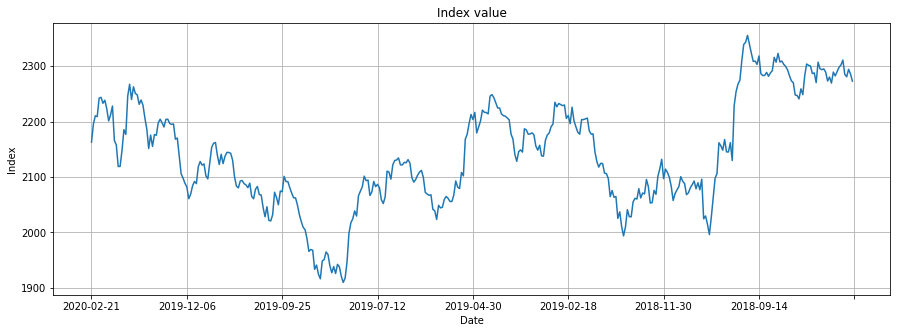

In [ ]:
plt.figure(figsize=(15,5))

df['End'] = df.End.apply(str).str.replace(",","").astype(float)
df['End'].plot(grid=True)
plt.ylabel('Index')
plt.title('Index value')

Date
2020-02-21     0.00
2020-02-20    32.66
2020-02-19    14.84
2020-02-18    -1.46
2020-02-17    33.29
Name: delta, dtype: float64


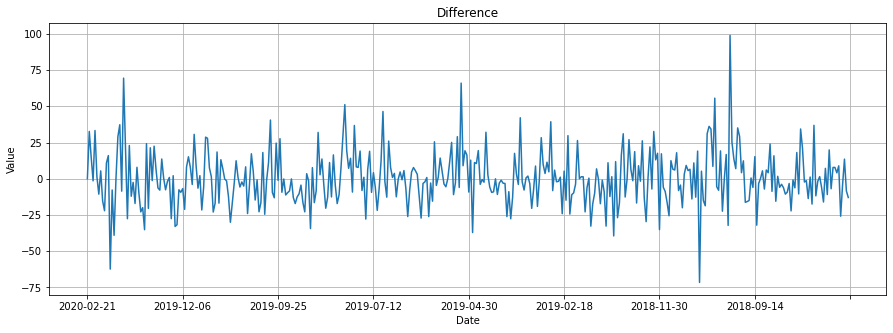

In [ ]:
#Add 0 at the beginning to match size
plt.figure(figsize=(15,5))
df['delta'] = np.append(np.array([0]), np.diff(df['End'].values))
df['delta'].plot(grid=True)
plt.ylabel('Value')
plt.title('Difference')
print(df['delta'].head())

In [ ]:
sp = np.fft.fft(df['delta'].values)
sp[:10]

array([ 110.03        +0.j        ,  -49.01095829+182.16141148j,
        153.13326658+506.85591062j, -248.55797068-113.27225179j,
        -45.81302731-299.7827327j ,  175.81131079+105.99524102j,
        472.62965158-161.0503465j ,  -74.9745623 -198.203j     ,
        323.98192547+697.92874718j, -639.64270427-289.60021042j])

#중첩의 원리를 통한 각각의 진폭을 더한 값을 통해 세타, 진폭, 진동수 구함.

In [ ]:
df['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(df)
numValuesHalf = numValues / 2
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)


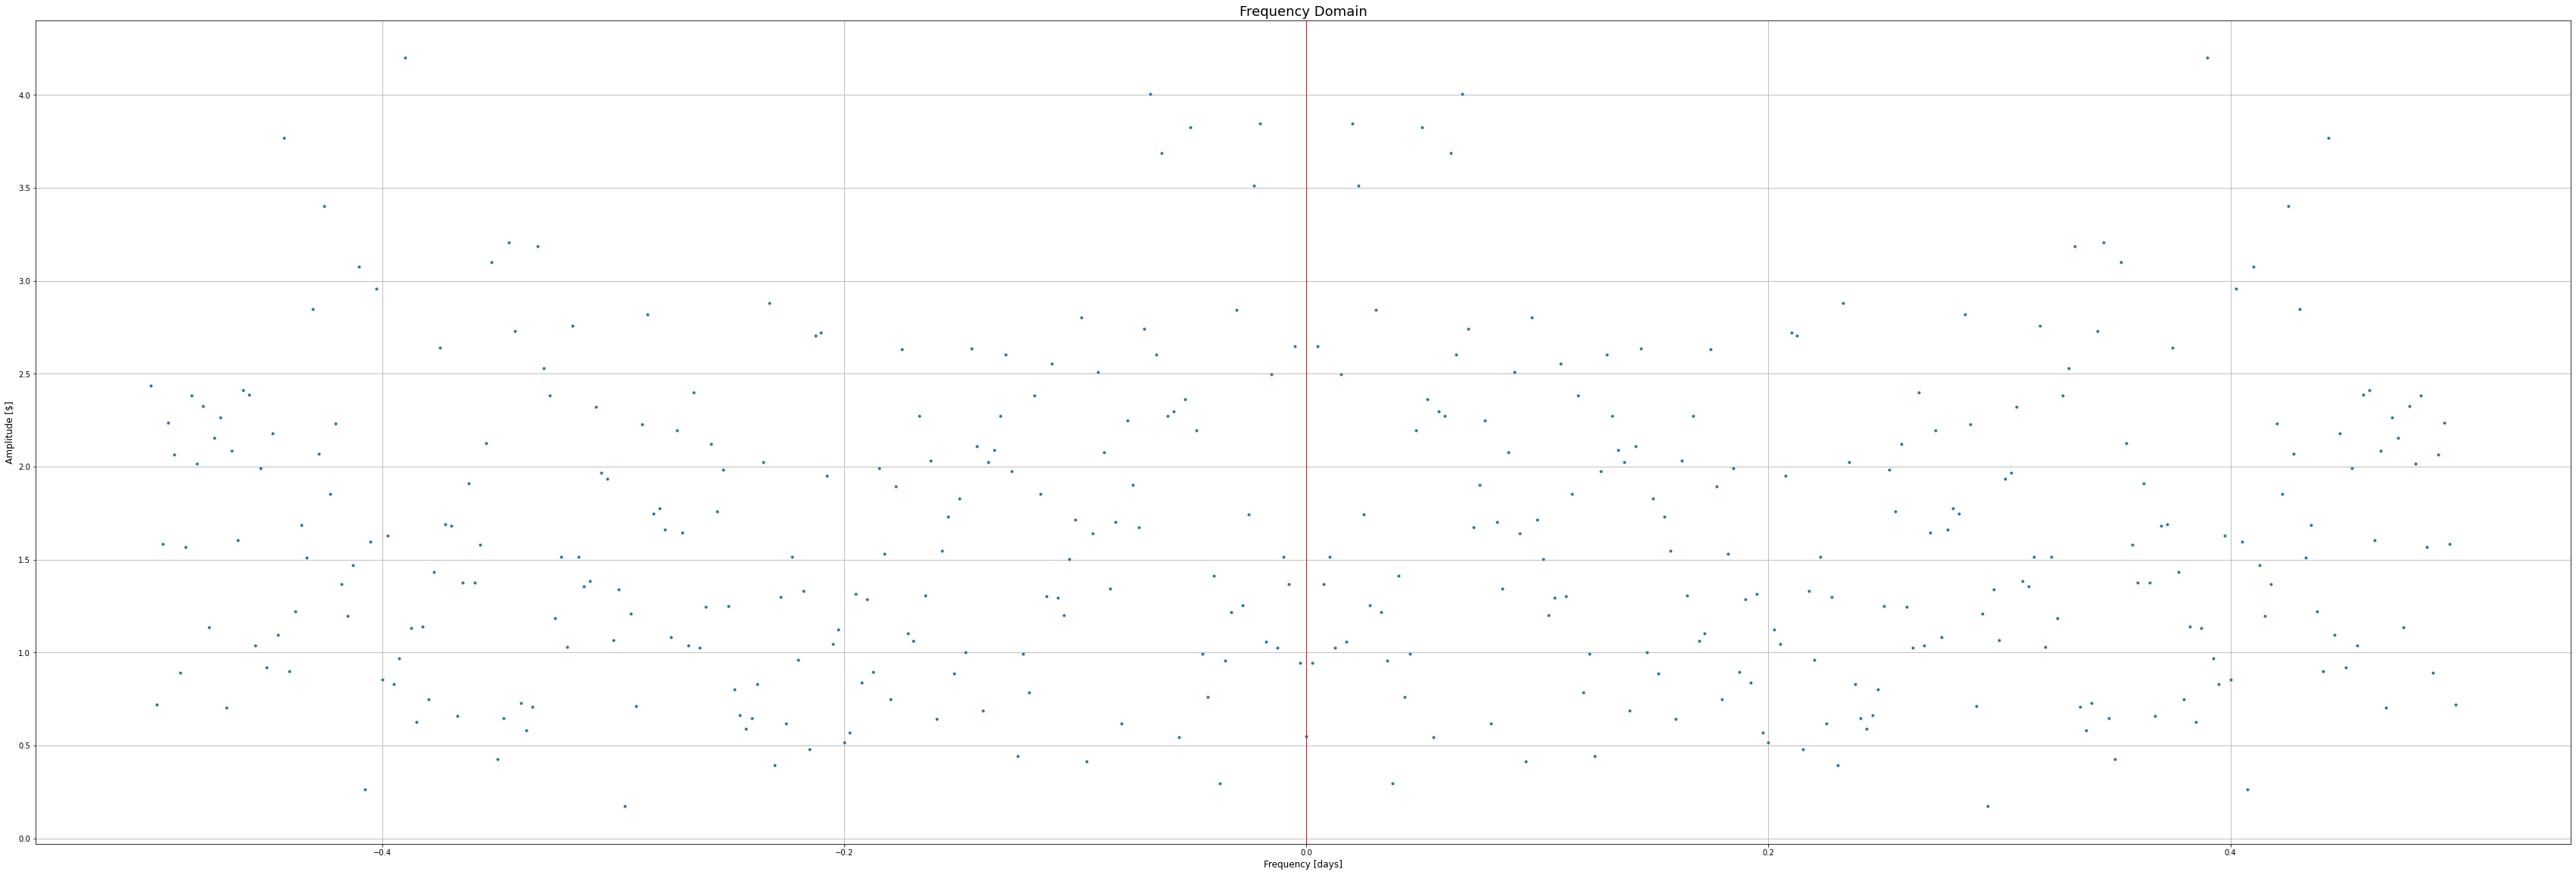

In [ ]:
plt.figure(figsize=(60,20))
plt.plot(df['freq'], df['amplitude'].values,'.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

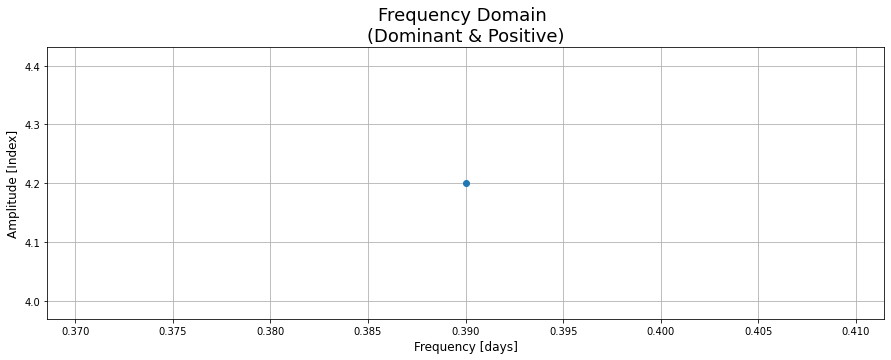

In [ ]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [Index]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

In [ ]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = df['End'][0]
regression = startValue + np.cumsum(regressionDelta)

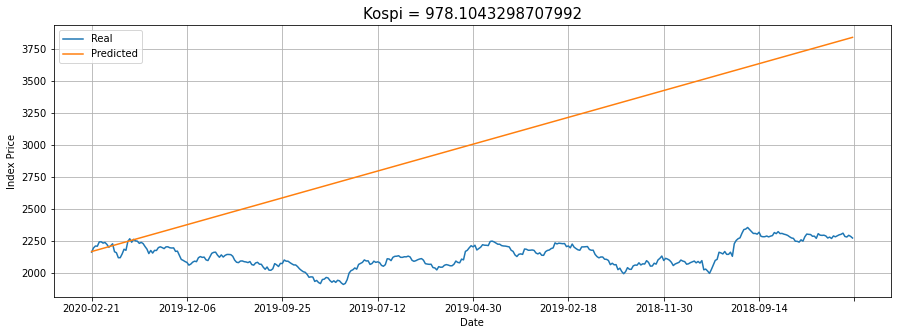

In [ ]:
plt.figure(figsize=(15,5))
df['End'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Index Price')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['End'].values - regression)**2))

plt.title('Kospi = ' + str(rmse), fontsize=15);